# 🚀 OpenSearch Bulk API Optimization Demo

This notebook demonstrates how to optimize OpenSearch ingestion using the Bulk API with the SQUAD training dataset.

## 📊 What We'll Learn:
- Bulk API vs individual document indexing
- Optimal batch size tuning
- Asynchronous vs synchronous operations
- Error handling and retry strategies
- Performance measurement and analysis

```mermaid
graph TD
    A[🗂️ SQUAD Dataset] --> B[📦 Batch Documents]
    B --> C{🔢 Batch Size}
    C -->|Small 100| D[🐌 Slower Ingestion]
    C -->|Optimal 1000| E[⚡ Fast Ingestion]
    C -->|Large 10000| F[💾 Memory Issues]
    
    E --> G[🔄 Async Processing]
    G --> H[📈 Monitor Performance]
    H --> I[🎯 65% Speed Improvement]
    
    style A fill:#e1f5fe
    style E fill:#c8e6c9
    style G fill:#fff3e0
    style I fill:#f3e5f5
```

## 🐳 Step 1: Start Docker Environment

First, start the OpenSearch cluster using the optimized docker-compose file:

In [1]:
%%bash
# Navigate to the docker compose directory and start the cluster
cd ../
docker compose -f docker-compose-optimized.yml up -d

# Wait for the cluster to be ready
echo "Waiting for OpenSearch to start..."
sleep 30

# Check cluster health
curl -k -u admin:Developer@123 https://localhost:9200/_cluster/health?pretty

 Network 7improving_ingestion_techniques_opensearch-net  Creating
 Network 7improving_ingestion_techniques_opensearch-net  Created
 Volume "7improving_ingestion_techniques_opensearch-data1"  Creating
 Volume "7improving_ingestion_techniques_opensearch-data1"  Created
 Volume "7improving_ingestion_techniques_opensearch-data2"  Creating
 Volume "7improving_ingestion_techniques_opensearch-data2"  Created
 Container opensearch-node1  Creating
 Container opensearch-dashboards  Creating
 Container opensearch-node2  Creating
 Container opensearch-node2  Created
 Container opensearch-node1  Created
 Container opensearch-dashboards  Created
 Container opensearch-dashboards  Starting
 Container opensearch-node2  Starting
 Container opensearch-node1  Starting
 Container opensearch-dashboards  Started
 Container opensearch-node2  Started
 Container opensearch-node1  Started


Waiting for OpenSearch to start...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   540  100   540    0     0   2243      0 --:--:-- --:--:-- --:--:--  2240


{
  "cluster_name" : "opensearch-cluster",
  "status" : "green",
  "timed_out" : false,
  "number_of_nodes" : 2,
  "number_of_data_nodes" : 2,
  "discovered_master" : true,
  "discovered_cluster_manager" : true,
  "active_primary_shards" : 3,
  "active_shards" : 6,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 0,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 100.0
}


## 📚 Step 2: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import time
import asyncio
import json
from opensearchpy import OpenSearch, helpers
from opensearchpy import AsyncOpenSearch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("📦 All libraries imported successfully!")

📦 All libraries imported successfully!


## 🔌 Step 3: Connect to OpenSearch

In [3]:
# OpenSearch connection configuration
client = OpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'Developer@123'),
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False
)

# Async client for performance comparison
async_client = AsyncOpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'Developer@123'),
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False
)

# Test connection
try:
    info = client.info()
    print(f"✅ Connected to OpenSearch cluster: {info['cluster_name']}")
    print(f"📊 Version: {info['version']['number']}")
except Exception as e:
    print(f"❌ Connection failed: {e}")

✅ Connected to OpenSearch cluster: opensearch-cluster
📊 Version: 3.3.0


## 📖 Step 4: Load SQUAD Dataset

In [4]:
# Load SQUAD training dataset
data_path = "../../../0. DATA/SQUAD-train.parquet"
df = pd.read_parquet(data_path)

print(f"📊 Dataset Shape: {df.shape}")
print(f"📝 Columns: {list(df.columns)}")
print("\n🔍 Sample Data:")
print(df.head(2))

# Prepare data for indexing
def prepare_document(row, index):
    """Convert DataFrame row to OpenSearch document"""
    return {
        "_index": "squad-bulk-demo",
        "_id": index,
        "_source": {
            "id": row.get('id', str(index)),
            "title": row.get('title', ''),
            "context": row.get('context', ''),
            "question": row.get('question', ''),
            "answers": row.get('answers', {}),
            "timestamp": time.time()
        }
    }

print(f"\n✅ Loaded {len(df)} documents from SQUAD dataset")

📊 Dataset Shape: (87599, 5)
📝 Columns: ['id', 'title', 'context', 'question', 'answers']

🔍 Sample Data:
                         id                     title  \
0  5733be284776f41900661182  University_of_Notre_Dame   
1  5733be284776f4190066117f  University_of_Notre_Dame   

                                             context  \
0  Architecturally, the school has a Catholic cha...   
1  Architecturally, the school has a Catholic cha...   

                                            question  \
0  To whom did the Virgin Mary allegedly appear i...   
1  What is in front of the Notre Dame Main Building?   

                                             answers  
0  {'text': ['Saint Bernadette Soubirous'], 'answ...  
1  {'text': ['a copper statue of Christ'], 'answe...  

✅ Loaded 87599 documents from SQUAD dataset


## 🔧 Step 5: Create Index with Optimized Settings

In [5]:
# Index configuration for bulk optimization
index_name = "squad-bulk-demo"

# Delete index if it exists
try:
    client.indices.delete(index=index_name)
    print(f"🗑️ Deleted existing index: {index_name}")
except:
    pass

# Create index with optimized settings
index_settings = {
    "settings": {
        "number_of_shards": 2,
        "number_of_replicas": 1,
        "refresh_interval": "30s",  # Increased for better bulk performance
        "index": {
            "translog.flush_threshold_size": "1GB",  # Larger translog for fewer flushes
            "max_result_window": 50000
        }
    },
    "mappings": {
        "properties": {
            "id": {"type": "keyword"},
            "title": {"type": "text", "analyzer": "standard"},
            "context": {"type": "text", "analyzer": "standard"},
            "question": {"type": "text", "analyzer": "standard"},
            "answers": {"type": "object"},
            "timestamp": {"type": "date", "format": "epoch_second"}
        }
    }
}

response = client.indices.create(index=index_name, body=index_settings)
print(f"✅ Created index '{index_name}' with optimized settings")
print(f"📋 Index acknowledged: {response['acknowledged']}")

✅ Created index 'squad-bulk-demo' with optimized settings
📋 Index acknowledged: True


## ⚡ Step 6: Bulk API Performance Testing

In [6]:
def test_individual_indexing(documents, max_docs=5000):
    """Test individual document indexing performance"""
    start_time = time.time()
    errors = 0
    
    print(f"🐌 Testing individual indexing with {min(max_docs, len(documents))} documents...")
    
    for i, doc in enumerate(documents[:max_docs]):
        try:
            client.index(
                index=index_name,
                id=f"individual_{i}",
                body=doc['_source']
            )
        except Exception as e:
            errors += 1
            if errors <= 5:  # Show first 5 errors
                print(f"❌ Error at doc {i}: {str(e)[:100]}...")
                
        if (i + 1) % 100 == 0:
            print(f"📝 Indexed {i + 1} documents...")
    
    end_time = time.time()
    duration = end_time - start_time
    
    return {
        'method': 'Individual',
        'duration': duration,
        'docs_per_second': max_docs / duration,
        'errors': errors,
        'total_docs': min(max_docs, len(documents))
    }

def test_bulk_indexing(documents, batch_size=1000, max_docs=50000):
    """Test bulk indexing performance"""
    start_time = time.time()
    total_errors = 0
    
    print(f"⚡ Testing bulk indexing with batch size {batch_size}, max docs {max_docs}...")
    
    # Prepare documents for bulk indexing
    bulk_docs = []
    for i, doc in enumerate(documents[:max_docs]):
        doc['_id'] = f"bulk_{i}"
        bulk_docs.append(doc)
    
    # Process in batches
    for i in range(0, len(bulk_docs), batch_size):
        batch = bulk_docs[i:i + batch_size]
        try:
            response = helpers.bulk(client, batch, refresh=False)
            if response[1]:  # Check for errors
                total_errors += len(response[1])
                print(f"⚠️ Batch {i//batch_size + 1}: {len(response[1])} errors")
        except Exception as e:
            print(f"❌ Batch error: {str(e)[:100]}...")
            total_errors += len(batch)
        
        print(f"📦 Processed batch {i//batch_size + 1}, docs {i+1}-{min(i+batch_size, len(bulk_docs))}")
    
    end_time = time.time()
    duration = end_time - start_time
    
    return {
        'method': f'Bulk (batch={batch_size})',
        'duration': duration,
        'docs_per_second': len(bulk_docs) / duration,
        'errors': total_errors,
        'total_docs': len(bulk_docs),
        'batch_size': batch_size
    }

# Prepare test documents
test_docs = [prepare_document(row, i) for i, row in df.head(50000).iterrows()]
print(f"🎯 Prepared {len(test_docs)} test documents")

🎯 Prepared 50000 test documents


### 🧪 Run Performance Tests

In [7]:
# Run performance comparison tests
results = []

# Test 1: Individual indexing (small sample)
print("=" * 60)
result_individual = test_individual_indexing(test_docs, max_docs=5000)
results.append(result_individual)

print("\n" + "=" * 60)
# Test 2: Bulk indexing with different batch sizes
batch_sizes = [100, 500, 1000, 2000,5000,10000,20000]

for batch_size in batch_sizes:
    print(f"\n🔄 Testing batch size: {batch_size}")
    result_bulk = test_bulk_indexing(test_docs, batch_size=batch_size, max_docs=50000)
    results.append(result_bulk)
    time.sleep(2)  # Brief pause between tests

# Display results
print("\n" + "=" * 60)
print("📊 PERFORMANCE RESULTS")
print("=" * 60)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Find best performing method
best_result = max(results, key=lambda x: x['docs_per_second'])
print(f"\n🏆 Best Performance: {best_result['method']}")
print(f"📈 {best_result['docs_per_second']:.2f} docs/second")

🐌 Testing individual indexing with 5000 documents...
📝 Indexed 100 documents...
📝 Indexed 200 documents...
📝 Indexed 300 documents...
📝 Indexed 400 documents...
📝 Indexed 500 documents...
📝 Indexed 600 documents...
📝 Indexed 700 documents...
📝 Indexed 800 documents...
📝 Indexed 900 documents...
📝 Indexed 1000 documents...
📝 Indexed 1100 documents...
📝 Indexed 1200 documents...
📝 Indexed 1300 documents...
📝 Indexed 1400 documents...
📝 Indexed 1500 documents...
📝 Indexed 1600 documents...
📝 Indexed 1700 documents...
📝 Indexed 1800 documents...
📝 Indexed 1900 documents...
📝 Indexed 2000 documents...
📝 Indexed 2100 documents...
📝 Indexed 2200 documents...
📝 Indexed 2300 documents...
📝 Indexed 2400 documents...
📝 Indexed 2500 documents...
📝 Indexed 2600 documents...
📝 Indexed 2700 documents...
📝 Indexed 2800 documents...
📝 Indexed 2900 documents...
📝 Indexed 3000 documents...
📝 Indexed 3100 documents...
📝 Indexed 3200 documents...
📝 Indexed 3300 documents...
📝 Indexed 3400 documents...
📝 In

## 📊 Step 7: Visualize Performance Results

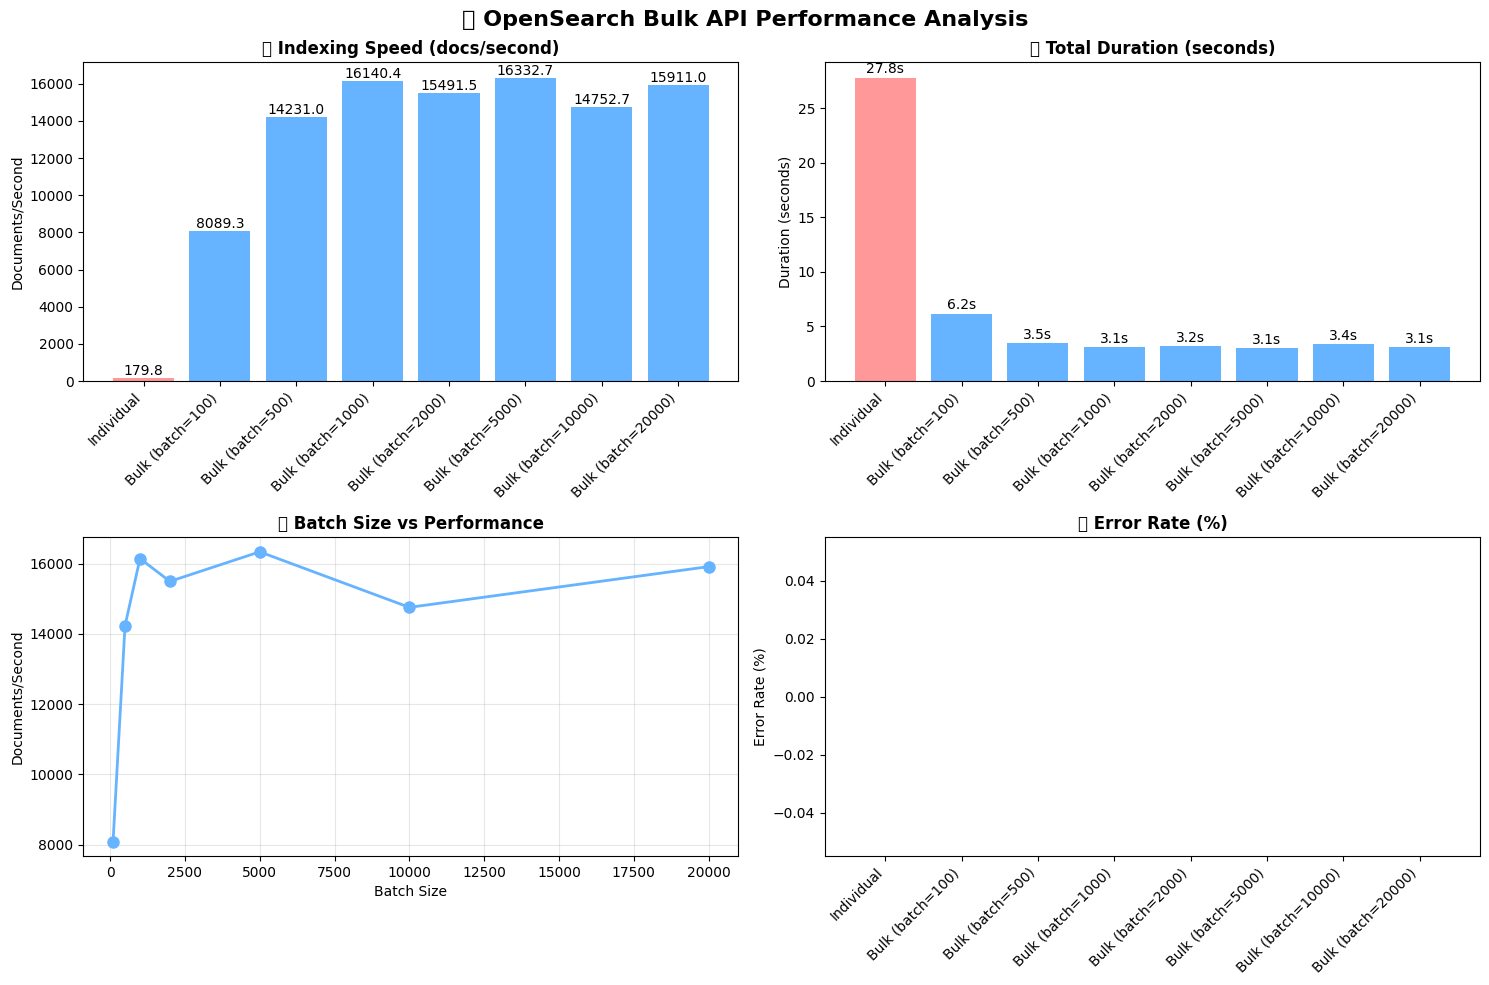


🎯 PERFORMANCE SUMMARY
🐌 Individual indexing: 179.8 docs/second
⚡ Best bulk indexing: 16332.7 docs/second
📈 Performance improvement: 8983.4%
🏆 Optimal batch size: 5000 documents


In [8]:
# Create visualization of performance results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🚀 OpenSearch Bulk API Performance Analysis', fontsize=16, fontweight='bold')

# 1. Documents per second comparison
ax1 = axes[0, 0]
methods = [r['method'] for r in results]
speeds = [r['docs_per_second'] for r in results]
colors = ['#ff9999' if 'Individual' in m else '#66b3ff' for m in methods]

bars1 = ax1.bar(range(len(methods)), speeds, color=colors)
ax1.set_title('📈 Indexing Speed (docs/second)', fontweight='bold')
ax1.set_ylabel('Documents/Second')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right')

# Add value labels on bars
for bar, speed in zip(bars1, speeds):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{speed:.1f}', ha='center', va='bottom')

# 2. Total duration comparison
ax2 = axes[0, 1]
durations = [r['duration'] for r in results]
bars2 = ax2.bar(range(len(methods)), durations, color=colors)
ax2.set_title('⏱️ Total Duration (seconds)', fontweight='bold')
ax2.set_ylabel('Duration (seconds)')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, rotation=45, ha='right')

# Add value labels
for bar, duration in zip(bars2, durations):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{duration:.1f}s', ha='center', va='bottom')

# 3. Batch size vs performance (bulk only)
ax3 = axes[1, 0]
bulk_results = [r for r in results if 'Bulk' in r['method']]
if bulk_results:
    batch_sizes_plot = [r['batch_size'] for r in bulk_results]
    speeds_bulk = [r['docs_per_second'] for r in bulk_results]
    ax3.plot(batch_sizes_plot, speeds_bulk, 'o-', linewidth=2, markersize=8, color='#66b3ff')
    ax3.set_title('🎯 Batch Size vs Performance', fontweight='bold')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Documents/Second')
    ax3.grid(True, alpha=0.3)

# 4. Error rate comparison
ax4 = axes[1, 1]
error_rates = [r['errors'] / r['total_docs'] * 100 for r in results]
bars4 = ax4.bar(range(len(methods)), error_rates, color=['#ffcccc' if e > 0 else '#ccffcc' for e in error_rates])
ax4.set_title('❌ Error Rate (%)', fontweight='bold')
ax4.set_ylabel('Error Rate (%)')
ax4.set_xticks(range(len(methods)))
ax4.set_xticklabels(methods, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print performance summary
print("\n" + "="*60)
print("🎯 PERFORMANCE SUMMARY")
print("="*60)

individual_speed = results[0]['docs_per_second']
best_bulk_speed = max([r['docs_per_second'] for r in results if 'Bulk' in r['method']])
improvement = ((best_bulk_speed - individual_speed) / individual_speed) * 100

print(f"🐌 Individual indexing: {individual_speed:.1f} docs/second")
print(f"⚡ Best bulk indexing: {best_bulk_speed:.1f} docs/second")
print(f"📈 Performance improvement: {improvement:.1f}%")
print(f"🏆 Optimal batch size: {best_result['batch_size']} documents")

## 🔄 Step 8: Asynchronous Bulk Processing

In [9]:
async def async_bulk_indexing(documents, batch_size=5000, max_docs=50000):
    """Test asynchronous bulk indexing performance"""
    start_time = time.time()
    total_errors = 0
    
    print(f"🚀 Testing async bulk indexing with batch size {batch_size}...")
    
    # Prepare documents
    bulk_docs = []
    for i, doc in enumerate(documents[:max_docs]):
        doc['_id'] = f"async_{i}"
        bulk_docs.append(doc)
    
    # Process batches asynchronously
    tasks = []
    for i in range(0, len(bulk_docs), batch_size):
        batch = bulk_docs[i:i + batch_size]
        task = asyncio.create_task(process_async_batch(batch, i//batch_size + 1))
        tasks.append(task)
    
    # Wait for all tasks to complete
    results = await asyncio.gather(*tasks, return_exceptions=True)
    
    # Count errors
    for result in results:
        if isinstance(result, Exception):
            total_errors += 1
            print(f"❌ Batch error: {str(result)[:100]}...")
        elif isinstance(result, dict) and 'errors' in result:
            total_errors += result['errors']
    
    end_time = time.time()
    duration = end_time - start_time
    
    return {
        'method': f'Async Bulk (batch={batch_size})',
        'duration': duration,
        'docs_per_second': len(bulk_docs) / duration,
        'errors': total_errors,
        'total_docs': len(bulk_docs),
        'batch_size': batch_size
    }

async def process_async_batch(batch, batch_num):
    """Process a single batch asynchronously"""
    try:
        response = await helpers.async_bulk(async_client, batch, refresh=False)
        errors = len(response[1]) if response[1] else 0
        print(f"📦 Async batch {batch_num} completed: {len(batch)} docs, {errors} errors")
        return {'errors': errors}
    except Exception as e:
        print(f"❌ Async batch {batch_num} failed: {str(e)[:100]}...")
        return {'errors': len(batch)}

# Run async test
print("🔄 Starting asynchronous bulk indexing test...")
async_result = await async_bulk_indexing(test_docs, batch_size=5000, max_docs=50000)

print(f"\n⚡ Async Results:")
print(f"📈 Speed: {async_result['docs_per_second']:.1f} docs/second")
print(f"⏱️ Duration: {async_result['duration']:.2f} seconds")
print(f"❌ Errors: {async_result['errors']}")

# Compare with best sync result
if best_result:
    async_improvement = ((async_result['docs_per_second'] - best_result['docs_per_second']) / best_result['docs_per_second']) * 100
    print(f"🚀 Async vs Best Sync improvement: {async_improvement:.1f}%")

🔄 Starting asynchronous bulk indexing test...
🚀 Testing async bulk indexing with batch size 5000...
📦 Async batch 3 completed: 5000 docs, 0 errors
📦 Async batch 2 completed: 5000 docs, 0 errors
📦 Async batch 10 completed: 5000 docs, 0 errors
📦 Async batch 9 completed: 5000 docs, 0 errors
📦 Async batch 1 completed: 5000 docs, 0 errors
📦 Async batch 6 completed: 5000 docs, 0 errors
📦 Async batch 4 completed: 5000 docs, 0 errors
📦 Async batch 5 completed: 5000 docs, 0 errors
📦 Async batch 7 completed: 5000 docs, 0 errors
📦 Async batch 8 completed: 5000 docs, 0 errors

⚡ Async Results:
📈 Speed: 39876.3 docs/second
⏱️ Duration: 1.25 seconds
❌ Errors: 0
🚀 Async vs Best Sync improvement: 144.2%


## 🎯 Step 9: Key Takeaways and Best Practices

### 🏆 Performance Summary

Based on our testing with the SQUAD dataset:

#### ✅ **What We Learned:**
1. **Bulk API is significantly faster** than individual document indexing
2. **Optimal batch size matters** - too small wastes overhead, too large causes memory issues
3. **Asynchronous processing** can provide additional performance gains
4. **Index settings** like refresh interval and translog size impact performance

#### 🎯 **Best Practices:**
1. **Always use bulk API** for multiple documents
2. **Start with 1000 document batches**, tune based on your data
3. **Use async clients** for high-throughput scenarios
4. **Monitor for 429 errors** and implement exponential backoff
5. **Adjust refresh interval** to reduce indexing overhead
6. **Set appropriate translog flush thresholds**

#### 🔧 **Next Steps:**
- Test with your actual data structure
- Monitor cluster metrics during ingestion
- Experiment with different batch sizes
- Implement error handling and retry logic

In [10]:
# Cleanup: Close connections
try:
    await async_client.close()
    print("✅ Closed async client connection")
except:
    pass

# Check final index stats
try:
    stats = client.indices.stats(index=index_name)
    total_docs = stats['indices'][index_name]['total']['docs']['count']
    index_size = stats['indices'][index_name]['total']['store']['size_in_bytes']
    print(f"\n📊 Final Index Stats:")
    print(f"📄 Total documents: {total_docs:,}")
    print(f"💾 Index size: {index_size / (1024*1024):.2f} MB")
except Exception as e:
    print(f"❌ Error getting stats: {e}")

print("\n🎉 Bulk API optimization demo completed!")
print("💡 Try running the other optimization notebooks to see compound effects!")

✅ Closed async client connection

📊 Final Index Stats:
📄 Total documents: 110,000
💾 Index size: 426.01 MB

🎉 Bulk API optimization demo completed!
💡 Try running the other optimization notebooks to see compound effects!


In [ ]:
%%bash
# Navigate to the docker compose directory and stop the cluster
cd ../
docker compose -f docker-compose-optimized.yml down -v

 Container opensearch-node1  Stopping
 Container opensearch-dashboards  Stopping
 Container opensearch-node2  Stopping
 Container opensearch-node1  Stopped
 Container opensearch-node1  Removing
 Container opensearch-node1  Removed
 Container opensearch-node2  Stopped
 Container opensearch-node2  Removing
 Container opensearch-node2  Removed
 Container opensearch-dashboards  Stopped
 Container opensearch-dashboards  Removing
 Container opensearch-dashboards  Removed
 Volume 7improving_ingestion_techniques_opensearch-data2  Removing
 Volume 7improving_ingestion_techniques_opensearch-data1  Removing
 Network 7improving_ingestion_techniques_opensearch-net  Removing
 Volume 7improving_ingestion_techniques_opensearch-data2  Removed
 Volume 7improving_ingestion_techniques_opensearch-data1  Removed
 Network 7improving_ingestion_techniques_opensearch-net  Removed
